In [1]:
import numpy as np
from scipy import signal
from pylab import *
import matplotlib.pyplot as plt
import scipy.io
import sklearn.metrics as skmetrics

# save numpy array as csv file
from numpy import asarray
from numpy import savetxt
# load numpy array from csv file
from numpy import loadtxt

In [2]:
"""
Function for initializing the graphic Equalizer

    Parameters
    ----------
    G_db : ndarray 31x1
        Command gains in dB
        
    Returns
    -------
    numsopt : ndarray
        numerator parts of the 31 filters
    densopt : ndarray
        denominator parts of the 31 filters
    fs : float
        sample frequency
    fc2 : ndarray
        center frequencies and additional design points between them
    G_db2 : ndarray
        interpolate target gains linearly b/w command gains
        
    Notes
    -----
    Python reference to Liski, J.; Välimäki, V. The quest for the best graphic equalizer. In Proceedings of the International Conference
    on Digital Audio Effects (DAFx-17), Edinburgh, UK, 5–9 September 2017; pp. 95–102

"""


def initGEQ(G_db):
    fs = 44.1e3
    #fc1 = 1000 * 2 ** ( 1/3 * arange(-17,14))
    fc1 = np.array([19.69,24.80,31.25,39.37,49.61,62.50,78.75,99.21,125.0,157.5,198.4,
    250.0,315.0,396.9,500.0,630.0,793.7,1000,1260,1587,2000,2520,3175,4000,
    5040,6350,8000,10080,12700,16000,20160])
    fc2 = np.zeros(61)
    fc2[::2] = fc1
    fc2[1::2] = np.sqrt(fc1[0:len(fc1)-1:1] * fc1[1::1])
    wg = 2*pi*fc1/fs
    wc = 2*pi*fc2/fs
    c= 0.38
    bw = np.array((2 ** (1/3) - 2 ** (-1/3)) * wg)
    bw_adjust = 2*pi/fs
    # Bänder aus acge3.m
    #bw[16::] = [370*bw_adjust, 466.2*bw_adjust, 587.4*bw_adjust, 740.1*bw_adjust, 932.4*bw_adjust, 1175*bw_adjust, 1480*bw_adjust, 1865*bw_adjust, 2350*bw_adjust, 2846*bw_adjust, 3502*bw_adjust, 4253*bw_adjust, 5038*bw_adjust, 5689*bw_adjust, 5570*bw_adjust]
    #bw[::] =[9.178*bw_adjust, 11.56*bw_adjust, 14.57*bw_adjust, 18.36*bw_adjust, 23.13*bw_adjust, 29.14*bw_adjust, 36.71*bw_adjust, 46.25*bw_adjust, 58.28*bw_adjust, 73.43*bw_adjust, 
    #92.51*bw_adjust, 116.6*bw_adjust, 146.9*bw_adjust, 185.0*bw_adjust, 233.1*bw_adjust, 293.7*bw_adjust,370*bw_adjust, 466.2*bw_adjust, 587.4*bw_adjust, 740.1*bw_adjust, 932.4*bw_adjust, 1175*bw_adjust, 1480*bw_adjust, 1865*bw_adjust, 2350*bw_adjust, 2846*bw_adjust, 3502*bw_adjust, 4253*bw_adjust, 5038*bw_adjust, 5689*bw_adjust, 5570*bw_adjust]
    # Bänder aus SGE initGEQ.m 
    bw[16::] = [369.7*bw_adjust, 465.8*bw_adjust, 586.8*bw_adjust, 739.3*bw_adjust, 930.6*bw_adjust, 1172*bw_adjust, 1476*bw_adjust, 1857*bw_adjust, 2338*bw_adjust, 2943*bw_adjust, 3704*bw_adjust, 4638*bw_adjust, 5684*bw_adjust, 6803*bw_adjust, 4117*bw_adjust]
    leak = interactionMatrix(10**(17/20)*np.ones(31),c,wg,wc,bw)
    
    B_mat = scipy.io.loadmat("initInterMatSGE3.mat")
    B = B_mat["B"]

    G_db2 = np.zeros([61,1])
    G_db2[::2] = G_db
    G_db2[1::2] = (G_db[:len(G_db)-1:1]+G_db[1::1])/2
    
    Gopt_db = np.linalg.lstsq(leak.conj().T, G_db2)[0]
    Gopt = 10**(Gopt_db/20)
    
    leak2 = interactionMatrix(Gopt,c,wg,wc,bw)
    G2opt_db = np.linalg.lstsq(leak2.conj().T, G_db2)[0] #filter gains
    G2opt = 10 **(G2opt_db/20)
    G2wopt_db = c * G2opt_db
    G2wopt = 10 **(G2wopt_db/20)
    
    numsopt = np.zeros((3,31))
    densopt = np.zeros((3,31))
    
    for k in range(31):
        [num,den] = pareq(G2opt[k],G2wopt[k],wg[k],bw[k])
        numsopt[:,k] = num
        densopt[:,k] = den
        
    
     #Code with InteractionMatrix SGE3
    g1 = np.linalg.lstsq(B.conj().T, G_db2)[0]
    G1 = 10**(g1/20)
    
        
    leakSGE3 = interactionMatrix_SGE3(G1,c,wg,wc,bw)
    G3opt_db = np.linalg.lstsq(leakSGE3.conj().T, G_db2)[0]
    [numsoptSGE3,densoptSGE3,G0] = design_band_filter(G3opt_db,c,wg,bw)
    
    
    return numsopt,densopt,fs,fc2,G_db2,numsoptSGE3,densoptSGE3,G0,G2opt_db,fc1

In [3]:
"""
Second-order parametric equalizing filter desigh with adjustable bandwidth gain

    Parameters
    ----------
    G : float64
        peak gain (linear)
    GB : float64
        bandwidth gain (linear)
    w0: float64
        center frequency (rads/sample)
    B : float64
        bandwidth (rads/sample)
    
    Returns
    -------
    num : ndarray
        numerator coefficients [b0,b1,b2]
    den : ndarray
        denominator coefficients [1,a1,a2]
        
    Notes
    -----
    Python reference to Liski, J.; Välimäki, V. The quest for the best graphic equalizer. In Proceedings of the International Conference
    on Digital Audio Effects (DAFx-17), Edinburgh, UK, 5–9 September 2017; pp. 95–102
    
"""
def pareq(G, GB, w0, B):
    if G == 1:
        beta = tan(B/2.)
    else: 
        beta = np.sqrt(abs(GB**2-1)/abs(G**2-GB**2))*tan(B/2)

    num = np.array([(1+G*beta), -2*cos(w0), (1-G*beta)]/(1+beta))
    den = np.array([1, -2*cos(w0)/(1+beta), (1-beta)/(1+beta)])
    
    return num, den

In [4]:
"""
Second-order parametric EQ with matching gain at Nyquist frequency

    Parameters
    ----------
    G0 : float64
        reference gain at DC (linear)
    G1 : float64
        nyquist-frequency gain
    G : float64
        peak gain (linear)
    GB : float64
        bandwidth gain (linear)
    w0: float64
        center frequency (rads/sample)
    Dw : float64
        bandwidth (rads/sample)
        
    Returns
    -------
    num : ndarray
        numerator coefficients [b0,b1,b2]
    den : ndarray
        denominator coefficients [1,a1,a2]
        
    Notes
    -----
    Python reference to Ramo, Liski and Välimäki 2020 Applied Sciences Paper Third-Octave and Bark Graphic-Equalizer Design with Symetric Band Filters
"""

def pareq_SGE3(G0,G1,G,GB,w0,Dw):
    if G == 1:
        b = np.array([1,0,0])
        a = b
    
    else:
        F = np.abs(G**2 - GB**2)
        G00 = np.abs(G**2 - G0**2)
        F00 = np.abs(GB**2 - G0**2)
        
        G01 = np.abs(G**2 - G0*G1)
        G11 = np.abs(G**2 - G1**2)
        F01 = np.abs(GB**2 - G0*G1)
        F11 = np.abs(GB**2 - G1**2)
        
        W2 = np.sqrt(G11/G00) * np.tan(w0/2)**2
        DW = (1 + np.sqrt(F00/F11) * W2) * tan(Dw/2)
        
        C = F11*DW**2-2*W2*(F01-np.sqrt(F00*F11))
        D = 2*W2*(G01-np.sqrt(G00*G11))
        
        A = np.sqrt((C+D)/F)
        B = np.sqrt((G**2*C+GB**2*D)/F)
        
        num = np.array([(G1+G0*W2+B), -2*(G1-G0*W2), (G1-B+G0*W2)]/(1+W2+A))
        den = np.array([1, (-2*(1-W2))/(1+W2+A), (1+W2-A)/(1+W2+A)])
    
        
    return num,den

In [5]:
"""
Compute the interaction matrix of a cascade GEQ

    Parameters
    ----------
    G : ndarray
        linear gain at which the leakage is determined    
    c : float
        gain factor at bandwidth (0.5 refers to db(G)/2)
    wg : ndarray
        command frequencies i.e. filter center frequencies (in rad/sample)
    wc : ndarray
        design frequencies (rad/sample) at which leakage is computed
    bw : ndarray 
        bandwidth of filters in radians
        
    Returns
    -------
    leak : ndarray
        N by M matrix showing how the magnitude responses of the band filters leak to the design frequencies.
        N is determined from the length of the array wc (number of design frequencies) whereas M is 
        determined from the length of wg (number of filters)
        
    Notes
    -----
    Python reference to Liski, J.; Välimäki, V. The quest for the best graphic equalizer. In Proceedings of the International Conference
    on Digital Audio Effects (DAFx-17), Edinburgh, UK, 5–9 September 2017; pp. 95–102
"""

def interactionMatrix(G,c,wg,wc,bw):

    M = len(wg)
    N = len(wc)
    leak = np.zeros([M,N]) 
    Gdb = 20 * np.log10(G)
    Gdbw = c * Gdb
    Gw = 10 ** (Gdbw/20)
    
    for m in range(M):
        [num, den] = pareq(G[m],Gw[m],wg[m],bw[m])
        w,h = signal.freqz(num, den, wc)
        Gain = 20*np.log10(np.abs(h))/Gdb[m]
        leak[m,:] = np.abs(Gain)
        
    return leak

In [6]:
"""
Band filter design for the symetric graphic equalizer.

    Parameters
    ----------
    g : ndarray
        opimized filter gains in dB
    c : float
        gain factor at bandwidth (0.5 refers to db(G)/2)
    wg : ndarray
        command frequencies i.e. filter center frequencies (in rad/sample)
    bw: ndarray
        bandwidth of filters in radians
        
    Returns
    -------
    nums : ndarray 3x31
        numerator coefficients for each filter
    dens : ndarray 3x31
        denominator coefficients for each filter
    G0 : float64
        direct Gain
        
    Notes
    -----
    Python reference to Rämö, J.; Liski, J.; Välimäki, V. Third-Octave and Bark Graphic-Equalizer Design with Symmetric Band Filters. 
    Appl. Sci. 2020, 10, 1222. 
    
"""
def design_band_filter(g,c,wg,bw):
    
    M = len(g)
    gw = c*g
    G =10**(g/20)
    Gw = 10**(gw/20)
    
    q1 = np.zeros(31)    
    q3 = np.zeros(31)
    q1[22::] = [0.00166, 0.00295, 0.00544, 0.0105, 0.0214, 0.0456, 0.103, 0.257, 0.754]
    q3[22::] = [8.09e-6, 1.25e-5, 1.91e-5, 2.84e-5, 4.08e-5, 5.46e-5, 6.27e-5, 3.68e-5, -1.18e-4 ]
    
    nums = np.zeros((3,M))
    dens = np.zeros((3,M))
    G0 = 1
    
    for m in range(M):
        gNq = q1[m]*g[m]*q3[m]*g[m]**3
        [num,den] = pareq_SGE3(1,10**(gNq/20),G[m],Gw[m],wg[m],bw[m])
        G0 = G0*num[0]
        nums[:,m] = num.T /num[0]
        dens[:,m] = den.T
    
    return nums, dens, G0
    

In [7]:
"""
Compute the interaction matrix of a cascade GEQ containing the leak factors to account for the band interaction when assigning filter gains. All filters 
are Orfanidis peak/notch filters with adjustbale bandwidth gain and Nyquist gain.

    Parameters
    ----------
    G : ndarray
        linear gain at which the leakage is determined    
    c : float
        gain factor at bandwidth (0.5 refers to db(G)/2)
    wg : ndarray
        command frequencies i.e. filter center frequencies (in rad/sample)
    wc : ndarray
        design frequencies (rad/sample) at which leakage is computed
    bw : ndarray 
        bandwidth of filters in radians
        
    Returns
    -------
    leak : ndarray
        N by M matrix showing how the magnitude responses of the band filters leak to the design frequencies.
        N is determined from the length of the array wc (number of design frequencies) whereas M is 
        determined from the length of wg (number of filters)
        
    Notes
    -----
    Python reference to Rämö, J.; Liski, J.; Välimäki, V. Third-Octave and Bark Graphic-Equalizer Design with Symmetric Band Filters. 
    Appl. Sci. 2020, 10, 1222. 
    
"""

def interactionMatrix_SGE3(G,c,wg,wc,bw):
    M = len(wg)
    N = len(wc)
    leak = np.zeros([M,N]) 
    Gdb = 20 * np.log10(G)
    Gdbw = c * Gdb
    Gw = 10 ** (Gdbw/20)
    
    Z = np.exp(-1j*wc)
    Z2 = Z**2
    
    q1 = np.zeros(31)   
    q3 = np.zeros(31)
    q1[22::] = [0.00166, 0.00295, 0.00544, 0.0105, 0.0214, 0.0456, 0.103, 0.257, 0.754]
    q3[22::] = [8.09e-6, 1.25e-5, 1.91e-5, 2.84e-5, 4.08e-5, 5.46e-5, 6.27e-5, 3.68e-5, -1.18e-4 ]
        
    gNq = np.zeros((31))
 
    
    for m in range(M):
        if any(Gdb):
            gNq[m] = q1[m]*Gdb[m]+q3[m]*Gdb[m]**3   #Nyguist gain
            G1  = 10**(gNq[m]/20)
            
            F = np.abs(G[m]**2 - Gw[m]**2)
            G00 = np.abs(G[m]**2 - 1)
            F00 = np.abs(Gw[m]**2 - 1)
        
            G01 = np.abs(G[m]**2 - G1)
            G11 = np.abs(G[m]**2 - G1**2)
            F01 = np.abs(Gw[m]**2 - G1)
            F11 = np.abs(Gw[m]**2 - G1**2)
        
            W2 = np.sqrt(G11/G00) * np.tan(wg[m]/2)**2
            DW = (1 + np.sqrt(F00/F11) * W2) * tan(bw[m]/2)
        
            C = F11*DW**2-2*W2*(F01-np.sqrt(F00*F11))
            D = 2*W2*(G01-np.sqrt(G00*G11))
        
            A = np.sqrt((C+D)/F)
            B = np.sqrt((G[m]**2*C+Gw[m]**2*D)/F)
        
            num = np.array([(G1+W2+B), -2*(G1-W2), (G1-B+W2)])/(1+W2+A)
            den = np.array([1, (-2*(1-W2))/(1+W2+A), (1+W2-A)/(1+W2+A)])
           
            
            H = (num[0]+num[1]*Z+num[2]*Z2)/(den[0]+den[1]*Z+den[2]*Z2)
            Gain = 20*np.log10(np.abs(H))/Gdb[m]
            leak[m,:] = np.abs(Gain)
            
        else: #if all gains are 0 dB
            temp = np.zeros((1,2*M^2-M))
            temp[0][::2*M+1] = 1
            leak = leak.reshape(temp,M,2*M-1)
            
    return leak

In [8]:
"""
Evaluate and plot

    Parameters
    ----------
    numsopt : ndarray
        numerator coefficients for each filter
    densopt : ndarray
        denominator coefficients for each filter
    fs : float
        sample frequency
    fc2 : ndarray
        center frequencies and additional design points between them
    G_db2 : ndarray
        interpolate target gains linearly b/w command gains
        
    Returns
    -------
    
    Notes
    -----
    Python reference to Liski, J.; Välimäki, V. The quest for the best graphic equalizer. In Proceedings of the International Conference
    on Digital Audio Effects (DAFx-17), Edinburgh, UK, 5–9 September 2017; pp. 95–102
    
"""

def plot(numsopt,densopt,fs,fc2,G_db2,G2opt_db,fc1):
    N_freq = 2 **12
    w = np.logspace(np.log10(9),np.log10(22050), N_freq)
    H_opt = np.ones((N_freq,31), dtype=complex)
    H_opt_tot = np.ones((N_freq,1), dtype=complex)
    
    for k in range(31):
        w, h = signal.freqz(numsopt[:,k], densopt[:,k],worN=w,fs=fs)
        H_opt[:,k]= h
        H_opt_tot = H_opt[:,[k]]  * H_opt_tot
    
    
    plt.semilogx(w,20*np.log10(np.abs(H_opt_tot)))
    plt.semilogx(w,20*np.log10(np.abs(H_opt)))
    plt.plot(fc2,G_db2, "ro", markersize=4, markerfacecolor="none")
    plt.plot(fc1,G2opt_db, "ro", markersize=4, markerfacecolor="none", marker="x")
    plt.ylabel("Magnitude [dB]")
    plt.xlabel("Frequency [Hz]")
    plt.title("Frequency response")
    plt.xticks([10, 30, 100, 1000, 3000, 10000])
    plt.yticks(np.arange(-20,20,5))
    plt.grid(which="both", linestyle="--", color="grey")
    plt.show()
    
    return w,H_opt_tot,fc2,G_db2,G2opt_db,fc1     #returns just for testing

In [9]:
"""
Evaluate and plot

    Parameters
    ----------
    numsoptSGE3 : ndarray
        numerator coefficients for each filter
    densoptSGE3 : ndarray
        denominator coefficients for each filter
    G0 : float64
        direct gain
    fs : float
        sample frequency
    fc2 : ndarray
        center frequencies and additional design points between them
    G_db2 : ndarray
        interpolate target gains linearly b/w command gains
        
    Returns
    -------
    
    Notes
    -----
    Python reference to Rämö, J.; Liski, J.; Välimäki, V. Third-Octave and Bark Graphic-Equalizer Design with Symmetric Band Filters. 
    Appl. Sci. 2020, 10, 1222. 
    
"""

def plotSGE3(numsoptSGE3,densoptSGE3,G0,fs,fc2,G_db2):
    
    N_freq = 2 **12
    w = np.logspace(np.log10(9),np.log10(22050), N_freq)
    H_opt = np.ones((N_freq,31), dtype=complex)
    H_opt_tot = np.ones((N_freq,1), dtype=complex)
    
    for k in range(31):
        w, h = signal.freqz(numsoptSGE3[:,k],densoptSGE3[:,k],worN=w,fs=fs)
        H_opt[:,k]= h
        H_opt_tot = H_opt[:,[k]]  * H_opt_tot
    
    H_opt_tot = G0*H_opt_tot
    
    plt.semilogx(w,20*np.log10(np.abs(H_opt_tot)))
    plt.plot(fc2,G_db2, "ro", markersize=4, markerfacecolor="none")
    plt.ylabel("Magnitude [dB]")
    plt.xlabel("Frequency [Hz]")
    plt.title("Frequency response")
    plt.xticks([10, 30, 100, 1000, 3000, 10000])
    plt.yticks(np.arange(-20,20,5))
    plt.grid(which="both", linestyle="--", color="grey")
    plt.show()
    
    return w,H_opt_tot,fc2,G_db2     #returns just for testing

In [10]:
xy_filter_mat = scipy.io.loadmat("xy_filter.mat")
xy_filter_mat.keys()
#xy_filter_mat["xy_filter"]
#xy_filter_mat["xy_filter"].shape

dict_keys(['__header__', '__version__', '__globals__', 'xy_filter'])

In [11]:
def plotAbsoluteError(numsopt,densopt,fs,G_db,fc1):
    N_freq = 31
    w = fc1
    H_opt = np.ones((N_freq,31), dtype=complex)
    H_opt_tot = np.ones((N_freq,1), dtype=complex)
    
    for k in range(31):
        w, h = signal.freqz(numsopt[:,k], densopt[:,k],worN=w,fs=fs)
        H_opt[:,k]= h
        H_opt_tot = H_opt[:,[k]]  * H_opt_tot
    
    e1 = 20*np.log10(np.abs(H_opt_tot)).T
    error = np.abs(e1-G_db)

    plt.semilogx(w,error[0])
    plt.ylabel("Error [dB]")
    plt.xlabel("Frequency [Hz]")
    plt.title("Absolute Error")
    #plt.xticks([10, 30, 100, 1000, 3000, 10000])
    #plt.yticks(np.arange(-20,20,5))
    plt.grid(which="both", linestyle="--", color="grey")
    plt.show()
    
    
    

In [12]:
def ErrorFunction(numsopt,densopt,fs,G_db,fc1):
    N_freq = 31
    w = fc1
    H_opt = np.ones((N_freq,31), dtype=complex)
    H_opt_tot = np.ones((N_freq,1), dtype=complex)
    
    for k in range(31):
        w, h = signal.freqz(numsopt[:,k], densopt[:,k],worN=w,fs=fs)
        H_opt[:,k]= h
        H_opt_tot = H_opt[:,[k]]  * H_opt_tot
    
    e1 = 20*np.log10(np.abs(H_opt_tot)).T
    error = np.abs(e1-G_db)
    error_MAE = mean(error)     # = MAE
    MSE = skmetrics.mean_squared_error(e1[0], G_db)
    RMSE = np.sqrt(MSE)
    MAE = skmetrics.mean_absolute_error(e1[0], G_db)
    
    return MSE, RMSE, MAE

In [13]:
def thirdOctaveGEQ():
    
    a = np.array([12,5,6,9,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,4,6,2]).reshape(31,1)
    b = np.array([12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12]).reshape(31,1)    
    c = np.array([12,-12,12,-12,12,-12,12,-12,12,-12,12,-12,12,-12,12,-12,12,-12,12,-12,12,-12,12,-12,12,-12,12,-12,12,-12,12]).reshape(31,1)    
    G_db = loadtxt('dataInput.csv', delimiter=',')[1105]
    G_db = a
    
    [numsopt,densopt,fs,fc2,G_db2,numsoptSGE3,densoptSGE3,G0,G2opt_db,fc1] = initGEQ(G_db.reshape(31,1)) #reshape to make it 31x1 instead of 1x31
    plot(numsopt,densopt,fs,fc2,G_db2,G2opt_db,fc1)
    plotAbsoluteError(numsopt,densopt,fs,G_db,fc1)
    plotSGE3(numsoptSGE3,densoptSGE3,G0,fs,fc2,G_db2)
    [MSE, RMSE, MAE] = ErrorFunction(numsopt,densopt,fs,G_db,fc1)
    
    return 

<ipython-input-2-faa8ba81a803>:59: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Gopt_db = np.linalg.lstsq(leak.conj().T, G_db2)[0]
<ipython-input-3-b6f18b782939>:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  num = np.array([(1+G*beta), -2*cos(w0), (1-G*beta)]/(1+beta))
<ipython-input-3-b6f18b782939>:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=

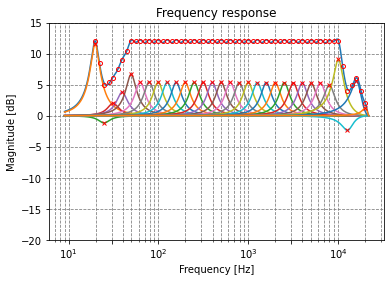

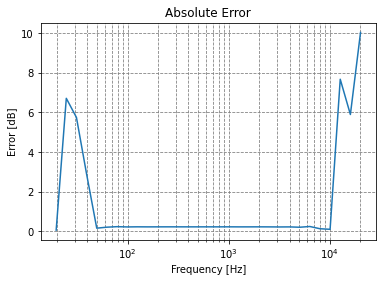

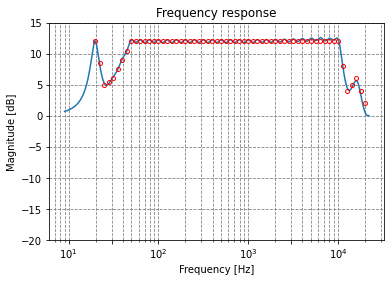

In [14]:
%matplotlib inline
thirdOctaveGEQ()

In [15]:
def createOutputData():
    
    dataInput = loadtxt('dataInput2.csv', delimiter=',')
    dataOutput = np.zeros((len(dataInput),31))
    dataError = np.zeros((len(dataInput),3))
    
    for i in range((len(dataInput))):
        #dataOutput[i] = initGEQ(dataInput[i].reshape(31,1))[8].T
        [numsopt,densopt,fs,fc2,G_db2,numsoptSGE3,densoptSGE3,G0,G2opt_db,fc1] = initGEQ(dataInput[i].reshape(31,1))
        dataOutput[i] = G2opt_db.T
        dataError[i] = ErrorFunction(numsopt,densopt,fs,dataInput[i].reshape(31,1),fc1)
    
    # define data
    data = asarray(dataOutput, dtype=np.float64,)
    # save to csv file
    savetxt('dataOutput2.csv', data, delimiter=',')
    
    # define data
    dataErr = asarray(dataError, dtype=np.float64,)
    # save to csv file
    savetxt('dataError2.csv', dataErr, delimiter=',')
    
    

In [16]:
createOutputData()

<ipython-input-2-faa8ba81a803>:59: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Gopt_db = np.linalg.lstsq(leak.conj().T, G_db2)[0]
<ipython-input-3-b6f18b782939>:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  num = np.array([(1+G*beta), -2*cos(w0), (1-G*beta)]/(1+beta))
<ipython-input-3-b6f18b782939>:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=

In [17]:
def Errors():
    
    dataError = loadtxt("dataError2.csv",delimiter=',').T
  

    maxMSE = np.max(dataError[0])
    maxRMSE = np.max(dataError[1])
    maxMAE = np.max(dataError[2])
   
    minMSE = np.min(dataError[0])
    minRMSE = np.min(dataError[1])
    minMAE = np.min(dataError[2])
    
    return maxMSE,maxRMSE,maxMAE, minMSE, minRMSE, minMAE

In [42]:
Errors()

(0.16277179096425887,
 0.4034498617725118,
 0.32351174911508085,
 0.010858533500189503,
 0.10420428734073038,
 0.07814565382689097)

In [18]:
Errors()

(0.14070920818114627,
 0.3751122607715539,
 0.32549855075216205,
 0.013783905620971487,
 0.11740487903392893,
 0.09019728704259823)